Step 1 Set up

In [56]:
import os
import subprocess

REPO_URL = "https://github.com/TranTruongMMCII/TrienKhaiModelDuDoanDuongDiCuaBao.git"
REPO_DIR = "/kaggle/working/TrienKhaiModelDuDoanDuongDiCuaBao"

if os.path.exists(REPO_DIR):
    print("Repository exists, pulling latest changes...")
    subprocess.run(["git", "-C", REPO_DIR, "pull"], check=True)
else:
    print("Cloning repository...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

import sys
if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)

os.chdir(f"{REPO_DIR}/tc_forecast")
print(f"Working directory: {os.getcwd()}")
print(f"Config file exists: {os.path.exists('config.yaml')}")

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU device: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

import psutil
ram = psutil.virtual_memory()
print(f"RAM: {ram.total/1024**3:.1f} GB")

Repository exists, pulling latest changes...
Already up to date.
Working directory: /kaggle/working/TrienKhaiModelDuDoanDuongDiCuaBao/tc_forecast
Config file exists: True
TensorFlow version: 2.19.0
GPU available: True
GPU device: /physical_device:GPU:0
RAM: 31.4 GB


Step 2 Config

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import gc
import os
import psutil

# Output directory
OUTPUT_DIR = "/kaggle/working/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/checkpoints", exist_ok=True)

def print_memory():
    ram = psutil.virtual_memory()
    print(f"RAM usage: {ram.used/1024**3:.1f}/{ram.total/1024**3:.1f} GB ({ram.percent}%)")

Configuration:
  Sample ratio: 1.0
  Batch size: 32
  Epochs: 100
  Learning rate: 0.001
RAM usage: 2.6/31.4 GB (9.9%)


Step 3 Load data

In [58]:
from tc_forecast.config import load_config
from tc_forecast.data_loader import TCDataLoader

config = load_config('config.yaml')

# Override paths for Kaggle environment (data is in data/ folder on GitHub)
config['data']['ibtracs_path'] = "../data/IBTrACS_Cleaned_Data.csv"
config['data']['atmospheric_data_dir'] = "../data/atmospheric_data_dir"

# Set seed
np.random.seed(config['training']['seed'])
tf.random.set_seed(config['training']['seed'])

loader = TCDataLoader(config)

track_path = config['data']['ibtracs_path']
atmos_dir = config['data']['atmospheric_data_dir']

print(f"Track data path: {track_path}")
print(f"Track file exists: {os.path.exists(track_path)}")
print(f"Atmospheric data dir: {atmos_dir}")
print(f"Atmospheric dir exists: {os.path.exists(atmos_dir)}")

# Check for atmospheric data
LOAD_ENV = False
if os.path.exists(atmos_dir):
    atmos_files = os.listdir(atmos_dir)
    print(f"Atmospheric files found: {atmos_files}")
    required_files = ['sst.csv', 'u300.csv', 'v300.csv', 'z300.csv']
    missing = [f for f in required_files if f not in atmos_files]
    if missing:
        print(f"Missing required files: {missing}")
    else:
        print("All required atmospheric files present")
        LOAD_ENV = True
else:
    print(f"Atmospheric data directory not found: {atmos_dir}")
    print("Will use GRU-only model")

print("\nLoading data...")
data = loader.load_and_prepare(track_path=track_path, load_env=LOAD_ENV)

X_train_track = data['X_train']
y_train = data['y_train']
X_val_track = data['X_val']
y_val = data['y_val']
X_test_track = data['X_test']
y_test = data['y_test']

env_train = data.get('env_train', None)
env_val = data.get('env_val', None)
env_test = data.get('env_test', None)

print(f"\nTrack data shapes:")
print(f"  Train: X={X_train_track.shape}, y={y_train.shape}")
print(f"  Val: X={X_val_track.shape}, y={y_val.shape}")
print(f"  Test: X={X_test_track.shape}, y={y_test.shape}")

USE_GRU_CNN = False
if env_train is not None and len(env_train) > 0:
    print(f"\nEnvironmental data loaded:")
    for key in env_train:
        arr = env_train[key]
        non_zero_pct = (arr != 0).sum() / arr.size * 100
        print(f"  {key}: shape={arr.shape}, non-zero={non_zero_pct:.1f}%")
    USE_GRU_CNN = True
else:
    print("\nNo environmental data - will use GRU-only model")

print_memory()

Track data path: ../data/IBTrACS_Cleaned_Data.csv
Track file exists: True
Atmospheric data dir: ../data/atmospheric_data_dir
Atmospheric dir exists: True
Atmospheric files found: ['sst.csv', 'z700.csv', 'u700.csv', 'u300.csv', 'z500.csv', 'v500.csv', 'v850.csv', 'v300.csv', 'u850.csv', 'v700.csv', 'z300.csv']
All required atmospheric files present

Loading data...
TC Forecast Data Loading Pipeline (Original Paper Method)
Loading track data from: /kaggle/working/TrienKhaiModelDuDoanDuongDiCuaBao/data/IBTrACS_Cleaned_Data.csv
Loaded 106306 rows, 10 columns
Columns: ['STORM_ID', 'NAME', 'ISO_TIME', 'LAT', 'LONG', 'STORM_DIR', 'STORM_SPEED', 'WMO_WIND', 'WMO_PRE', 'LANDFALL']
Raw IBTrACS data detected - computing derived features...
Computed 19 derived features for 1508 storms
Created 78137 track sequences from 1508 storms
Track X shape: (78137, 8, 11), y shape: (78137, 24)
Using 11 features: ['ANG', 'LON', 'DIF_DIRECT', 'X_DIST', 'DIF_LON', 'LAT', 'DIF_SPEED', 'F2', 'Y_DIST', 'P', 'WS']
L

Step 4 Process data

In [59]:
# Convert to float32
X_train_track = X_train_track.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val_track = X_val_track.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test_track = X_test_track.astype(np.float32)
y_test = y_test.astype(np.float32)

# Check for NaN/Inf values
print("Checking data quality...")
print(f"  X_train NaN count: {np.isnan(X_train_track).sum()}")
print(f"  y_train NaN count: {np.isnan(y_train).sum()}")

# Replace NaN/Inf with 0
X_train_track = np.nan_to_num(X_train_track, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val_track = np.nan_to_num(X_val_track, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test_track = np.nan_to_num(X_test_track, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize track data (StandardScaler)
print("\nNormalizing track data...")
n_samples, seq_len, n_features = X_train_track.shape
X_train_2d = X_train_track.reshape(-1, n_features)

X_mean = X_train_2d.mean(axis=0)
X_std = X_train_2d.std(axis=0)
X_std[X_std == 0] = 1

X_train_track = ((X_train_track.reshape(-1, n_features) - X_mean) / X_std).reshape(X_train_track.shape)
X_val_track = ((X_val_track.reshape(-1, n_features) - X_mean) / X_std).reshape(X_val_track.shape)
X_test_track = ((X_test_track.reshape(-1, n_features) - X_mean) / X_std).reshape(X_test_track.shape)

# Normalize target data
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_std[y_std == 0] = 1

y_train_norm = (y_train - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

print(f"  X normalized: mean={X_train_track.mean():.4f}, std={X_train_track.std():.4f}")
print(f"  y normalized: mean={y_train_norm.mean():.4f}, std={y_train_norm.std():.4f}")

# Initialize env data dicts
env_train_norm = {}
env_val_norm = {}
env_test_norm = {}

# Process environmental data if available
if env_train is not None and len(env_train) > 0:
    print("\nNormalizing environmental data...")
    env_means = {}
    env_stds = {}
    
    for key in env_train:
        data_train = env_train[key].astype(np.float32)
        data_val = env_val[key].astype(np.float32)
        data_test = env_test[key].astype(np.float32)
        
        data_train = np.nan_to_num(data_train, nan=0.0)
        data_val = np.nan_to_num(data_val, nan=0.0)
        data_test = np.nan_to_num(data_test, nan=0.0)
        
        mean_val = data_train.mean()
        std_val = data_train.std()
        if std_val == 0:
            std_val = 1
        
        env_train_norm[key] = (data_train - mean_val) / std_val
        env_val_norm[key] = (data_val - mean_val) / std_val
        env_test_norm[key] = (data_test - mean_val) / std_val
        env_means[key] = mean_val
        env_stds[key] = std_val
        
        print(f"  {key}: shape={data_train.shape}")

gc.collect()

# Get dimensions
SEQ_LENGTH = X_train_track.shape[1]
N_FEATURES = X_train_track.shape[2]
OUTPUT_SIZE = y_train.shape[1]

print(f"\nData dimensions:")
print(f"  Sequence length: {SEQ_LENGTH}")
print(f"  Number of features: {N_FEATURES}")
print(f"  Output size: {OUTPUT_SIZE}")
print_memory()

Checking data quality...
  X_train NaN count: 102097
  y_train NaN count: 0

Normalizing track data...
  X normalized: mean=0.0005, std=1.0001
  y normalized: mean=-0.0000, std=1.0000

Normalizing environmental data...
  sst: shape=(54695, 1, 21, 21)
  uv: shape=(54695, 8, 21, 21)
  z: shape=(54695, 3, 46, 81)

Data dimensions:
  Sequence length: 8
  Number of features: 11
  Output size: 24
RAM usage: 15.3/31.4 GB (50.2%)


Step 5 Dataset

In [60]:
# Check if we have actual environmental data (not empty)
HAS_ENV_DATA = (
    env_train is not None and 
    len(env_train) > 0 and 
    any(env_train[k].size > 0 for k in env_train)
)

USE_GRU_CNN = HAS_ENV_DATA
print(f"Environmental data available: {HAS_ENV_DATA}")

# Prepare training data based on model type
if USE_GRU_CNN:
    print("Creating multi-input dataset for GRU-CNN...")
    
    # GRU-CNN expects inputs: [track, uv, sst, z]
    train_inputs = [
        X_train_track,
        env_train_norm.get('uv', np.zeros((len(X_train_track), 8, 21, 21), dtype=np.float32)),
        env_train_norm.get('sst', np.zeros((len(X_train_track), 1, 21, 21), dtype=np.float32)),
        env_train_norm.get('z', np.zeros((len(X_train_track), 3, 21, 21), dtype=np.float32))
    ]
    val_inputs = [
        X_val_track,
        env_val_norm.get('uv', np.zeros((len(X_val_track), 8, 21, 21), dtype=np.float32)),
        env_val_norm.get('sst', np.zeros((len(X_val_track), 1, 21, 21), dtype=np.float32)),
        env_val_norm.get('z', np.zeros((len(X_val_track), 3, 21, 21), dtype=np.float32))
    ]
    test_inputs = [
        X_test_track,
        env_test_norm.get('uv', np.zeros((len(X_test_track), 8, 21, 21), dtype=np.float32)),
        env_test_norm.get('sst', np.zeros((len(X_test_track), 1, 21, 21), dtype=np.float32)),
        env_test_norm.get('z', np.zeros((len(X_test_track), 3, 21, 21), dtype=np.float32))
    ]
    
    print(f"Train inputs: track={train_inputs[0].shape}, uv={train_inputs[1].shape}, sst={train_inputs[2].shape}, z={train_inputs[3].shape}")
else:
    print("Creating single-input dataset for GRU-only...")
    train_inputs = X_train_track
    val_inputs = X_val_track
    test_inputs = X_test_track
    
    print(f"Train input: {train_inputs.shape}")

train_targets = y_train_norm
val_targets = y_val_norm
test_targets = y_test_norm

print(f"Train samples: {len(y_train_norm)}")
print(f"Val samples: {len(y_val_norm)}")
print(f"Test samples: {len(y_test_norm)}")

Environmental data available: True
Creating multi-input dataset for GRU-CNN...
Train inputs: track=(54695, 8, 11), uv=(54695, 8, 21, 21), sst=(54695, 1, 21, 21), z=(54695, 3, 46, 81)
Train samples: 54695
Val samples: 11721
Test samples: 11721


Step 6 Build Model

In [61]:
from tc_forecast.model import TCForecastModel

# Set model type based on data availability
if USE_GRU_CNN:
    config['model']['type'] = "GRU_CNN"
    print("Model type: GRU_CNN (with environmental data)")
else:
    config['model']['type'] = "GRU"
    print("Model type: GRU (track data only)")

tc_model = TCForecastModel(config)

# Build model with appropriate shapes
track_shape = (SEQ_LENGTH, N_FEATURES)

if USE_GRU_CNN:
    uv_shape = env_train_norm.get('uv', np.zeros((1, 8, 21, 21))).shape[1:] if env_train_norm.get('uv') is not None else (8, 21, 21)
    sst_shape = env_train_norm.get('sst', np.zeros((1, 1, 21, 21))).shape[1:] if env_train_norm.get('sst') is not None else (1, 21, 21)
    z_shape = env_train_norm.get('z', np.zeros((1, 3, 21, 21))).shape[1:] if env_train_norm.get('z') is not None else (3, 21, 21)
    
    print(f"Input shapes:")
    print(f"  Track: {track_shape}")
    print(f"  UV: {uv_shape}")
    print(f"  SST: {sst_shape}")
    print(f"  Z: {z_shape}")
    
    model = tc_model.build(
        track_shape=track_shape,
        uv_shape=uv_shape,
        sst_shape=sst_shape,
        z_shape=z_shape
    )
else:
    print(f"Input shape: Track {track_shape}")
    model = tc_model.build(track_shape=track_shape)

learning_rate = config['training']['learning_rate']
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print(f"\nModel: {model.name}")
print(f"Total parameters: {model.count_params():,}")
model.summary()

Model type: GRU_CNN (with environmental data)
Input shapes:
  Track: (8, 11)
  UV: (8, 21, 21)
  SST: (1, 21, 21)
  Z: (3, 46, 81)
Model compiled with adam optimizer, mse loss

Model: TC_GRU_CNN_Model
Total parameters: 950,680


Model: "TC_GRU_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ uv_input            │ (None, 8, 21, 21) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_input           │ (None, 1, 21, 21) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_input             │ (None, 3, 46, 81) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uv_permute          │ (None, 21, 21, 8) │          0 │ uv_input[0][0]    │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_permute         │ (None, 21, 21, 1) │          0 │ sst_input[0][0]   │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_permute (Permute) │ (None, 46, 81, 3) │          0 │ z_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uv_conv_1 (Conv2D)  │ (None, 21, 21,    │      2,336 │ uv_permute[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_conv_1 (Conv2D) │ (None, 21, 21,    │        160 │ sst_permute[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_conv_1 (Conv2D)   │ (None, 46, 81,    │        896 │ z_permute[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uv_bn_1             │ (None, 21, 21,    │        128 │ uv_conv_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_bn_1            │ (None, 21, 21,    │         64 │ sst_conv_1[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_bn_1              │ (None, 46, 81,    │        128 │ z_conv_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uv_pool_1           │ (None, 11, 11,    │          0 │ uv_bn_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_pool_1          │ (None, 11, 11,    │          0 │ sst_bn_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_pool_1            │ (None, 23, 41,    │          0 │ z_bn_1[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uv_drop_1 (Dropout) │ (None, 11, 11,    │          0 │ uv_pool_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_drop_1          │ (None, 11, 11,    │          0 │ sst_pool_1[0][0]  │
│ (Dropout)           │ 16)               │            │                 

 Total params: 950,680 (3.63 MB)

 Trainable params: 949,560 (3.62 MB)

 Non-trainable params: 1,120 (4.38 KB)

Step 7 Training

In [62]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=config['training']['early_stop_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=f"{OUTPUT_DIR}/checkpoints/best_model.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=config['training']['lr_reduce_patience'],
        min_lr=1e-7,
        verbose=1
    )
]

print("Starting training...")
print(f"  Model type: {config['model']['type']}")
print(f"  Epochs: {config['training']['epochs']}")
print(f"  Batch size: {config['training']['batch_size']}")

start_time = time.time()

history = model.fit(
    train_inputs,
    train_targets,
    validation_data=(val_inputs, val_targets),
    batch_size=config['training']['batch_size'],
    epochs=config['training']['epochs'],
    callbacks=callbacks,
    verbose=1
)

total_time = time.time() - start_time
best_val_loss = min(history.history['val_loss'])

print(f"\nTraining completed in {total_time/60:.1f} minutes")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Epochs trained: {len(history.history['loss'])}")

Starting training...
  Model type: GRU_CNN
  Epochs: 100
  Batch size: 32
Epoch 1/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5810 - mae: 0.5156
Epoch 1: val_loss improved from inf to 0.56862, saving model to /kaggle/working/output/checkpoints/best_model.keras
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 70s 25ms/step - loss: 0.5809 - mae: 0.5156 - val_loss: 0.5686 - val_mae: 0.5659 - learning_rate: 0.0010
Epoch 2/100
1707/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3273 - mae: 0.3972
Epoch 2: val_loss improved from 0.56862 to 0.29262, saving model to /kaggle/working/output/checkpoints/best_model.keras
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.3273 - mae: 0.3972 - val_loss: 0.2926 - val_mae: 0.3710 - learning_rate: 0.0010
Epoch 3/100
1708/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3071 - mae: 0.3830
Epoch 3: val_loss did not improve from 0.29262
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.3071 - mae: 0.3830 - val_loss: 0.2937 - val_mae: 0.3716 - learn

Step 8 Evaluation

In [63]:
model_path = f"{OUTPUT_DIR}/checkpoints/best_model.keras"
if os.path.exists(model_path):
    model = keras.models.load_model(model_path)
    print("Loaded best model from checkpoint")
else:
    print("Using current model (no checkpoint found)")

print("Evaluating on test set...")
test_preds_norm = model.predict(test_inputs, verbose=1)

# Denormalize predictions
test_preds = test_preds_norm * y_std + y_mean
test_targets = y_test

print(f"Predictions shape: {test_preds.shape}")
print(f"Targets shape: {test_targets.shape}")


def haversine(lat1, lon1, lat2, lon2):
    """Calculate haversine distance in kilometers."""
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


# Reshape predictions: (samples, 24) -> (samples, 12, 2)
pred_reshape = test_preds.reshape(-1, 12, 2)
true_reshape = test_targets.reshape(-1, 12, 2)

# Calculate metrics per forecast hour
forecast_hours = [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]
metrics = []

print(f"\n{'Hour':>6} | {'RMSE':>10} | {'MAE':>10} | {'Distance (km)':>14}")
print("-" * 50)

for i, hour in enumerate(forecast_hours):
    pred_lat, pred_lon = pred_reshape[:, i, 0], pred_reshape[:, i, 1]
    true_lat, true_lon = true_reshape[:, i, 0], true_reshape[:, i, 1]
    
    rmse = np.sqrt(np.mean((pred_lat - true_lat)**2 + (pred_lon - true_lon)**2))
    mae = np.mean(np.abs(pred_lat - true_lat) + np.abs(pred_lon - true_lon)) / 2
    dist = np.mean(haversine(pred_lat, pred_lon, true_lat, true_lon))
    
    metrics.append({'hour': hour, 'rmse': rmse, 'mae': mae, 'distance_km': dist})
    print(f"{hour:>6}h | {rmse:>10.4f} | {mae:>10.4f} | {dist:>14.1f}")

print("\nKey forecast errors:")
for m in metrics:
    if m['hour'] in [24, 48, 72]:
        print(f"  {m['hour']}h: {m['distance_km']:.1f} km")

Loaded best model from checkpoint
Evaluating on test set...
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Predictions shape: (11721, 24)
Targets shape: (11721, 24)

  Hour |       RMSE |        MAE |  Distance (km)
--------------------------------------------------
     6h |     0.0348 |     0.0170 |            3.0
    12h |     0.0456 |     0.0217 |            3.9
    18h |     0.0518 |     0.0251 |            4.5
    24h |     0.0528 |     0.0262 |            4.6
    30h |     0.0585 |     0.0293 |            5.1
    36h |     0.0637 |     0.0321 |            5.6
    42h |     0.0694 |     0.0350 |            6.1
    48h |     0.0745 |     0.0377 |            6.6
    54h |     0.0795 |     0.0404 |            7.1
    60h |     0.0845 |     0.0430 |            7.5
    66h |     0.0891 |     0.0454 |            7.9
    72h |     0.0937 |     0.0478 |            8.3

Key forecast errors:
  24h: 4.6 km
  48h: 6.6 km
  72h: 8.3 km


Step 9 Visualization

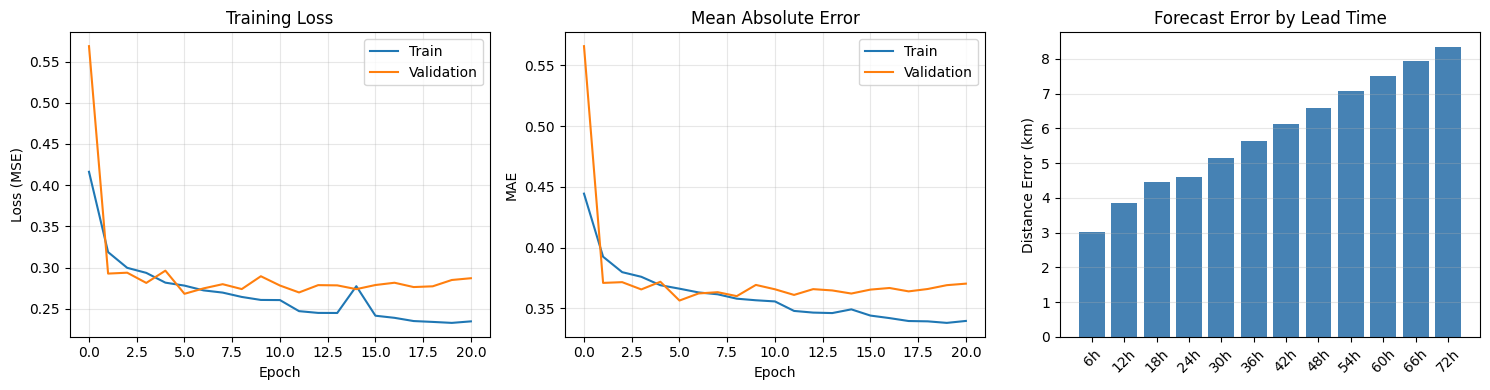

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE curve
axes[1].plot(history.history['mae'], label='Train')
axes[1].plot(history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Forecast error by lead time
hours = [m['hour'] for m in metrics]
dists = [m['distance_km'] for m in metrics]
axes[2].bar(range(len(hours)), dists, color='steelblue')
axes[2].set_xticks(range(len(hours)))
axes[2].set_xticklabels([f'{h}h' for h in hours], rotation=45)
axes[2].set_ylabel('Distance Error (km)')
axes[2].set_title('Forecast Error by Lead Time')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_results.png', dpi=150)
plt.show()

Step 10 Results

In [65]:
import json

# Save metrics
pd.DataFrame(metrics).to_csv(f'{OUTPUT_DIR}/metrics.csv', index=False)

# Save predictions
np.save(f'{OUTPUT_DIR}/test_predictions.npy', test_preds)
np.save(f'{OUTPUT_DIR}/test_targets.npy', test_targets)

# Save normalization parameters
np.savez(f'{OUTPUT_DIR}/normalization_params.npz',
         X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std)

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{OUTPUT_DIR}/training_history.csv', index=False)

# Save summary (convert numpy types to Python native types for JSON)
def to_python_type(val):
    if val is None:
        return None
    if isinstance(val, (np.floating, np.float32, np.float64)):
        return float(val)
    if isinstance(val, (np.integer, np.int32, np.int64)):
        return int(val)
    return val

summary = {
    'model': model.name,
    'model_type': config['model']['type'],
    'framework': 'TensorFlow/Keras',
    'tensorflow_version': tf.__version__,
    'use_gru_cnn': USE_GRU_CNN,
    'batch_size': config['training']['batch_size'],
    'epochs_trained': len(history.history['loss']),
    'best_val_loss': to_python_type(best_val_loss) if not np.isnan(best_val_loss) else None,
    'training_time_minutes': to_python_type(total_time / 60),
    'test_samples': len(test_preds),
    'key_errors_km': {
        '24h': to_python_type(next((m['distance_km'] for m in metrics if m['hour'] == 24), None)),
        '48h': to_python_type(next((m['distance_km'] for m in metrics if m['hour'] == 48), None)),
        '72h': to_python_type(next((m['distance_km'] for m in metrics if m['hour'] == 72), None))
    }
}

with open(f'{OUTPUT_DIR}/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Results saved to:")
print(f"  {OUTPUT_DIR}/metrics.csv")
print(f"  {OUTPUT_DIR}/test_predictions.npy")
print(f"  {OUTPUT_DIR}/training_history.csv")
print(f"  {OUTPUT_DIR}/summary.json")
print(f"  {OUTPUT_DIR}/checkpoints/best_model.keras")

err_24 = summary['key_errors_km']['24h']
err_48 = summary['key_errors_km']['48h']
err_72 = summary['key_errors_km']['72h']

print(f"\nTraining complete!")
print(f"Model: {summary['model']} ({summary['model_type']})")
print(f"Forecast errors: 24h={err_24:.1f}km, 48h={err_48:.1f}km, 72h={err_72:.1f}km")

TypeError: Object of type float32 is not JSON serializable